# Run a Gene Ontology Enrichment Analysis (GOEA)
* Use gene clusters (chi-square p value filter; louvain clustering) resulted from .ipynb #9. 
* Calculate enriched GO terms and plot barplots

In [1]:
import sys
import pickle
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_diffxpy/bin/python
['/home2/s418610/jupyter_notebooks/Invivo_neuronal_reprogramming/Cluster_with_10x/Remapped_10X_data/Harmony.4', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/batchglm', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/diffxpy', '/h

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scanpy as sc
import anndata

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import scanpy as sc
# import harmonypy as hm

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
# sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
# print('scipy', scipy.__version__)
# print('sklearn', sklearn.__version__)
print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

sc.logging.print_versions()

!date +%F

numpy 1.17.2
pandas 0.25.2
statsmodels 0.10.1
matplotlib 3.1.3
seaborn 0.9.0
scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
2020-07-24


## 1. Download Ontologies and Associations

### 1a. Download Ontologies, if necessary

In [4]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


### 1b. Download Associations, if necessary

In [5]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

  EXISTS: gene2go


## 2. Load Ontologies, Associations and Background gene set 

### 2a. Load Ontologies

In [6]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2020-05-02) 47,240 GO Terms


### 2b. Load Associations

In [7]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

In [8]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090]) # Taxid 10090 is Mus musculus

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:03.987523 380,584 annotations READ: gene2go 
1 taxids stored: 10090
CC 19,048 annotated mouse genes
MF 16,917 annotated mouse genes
BP 18,229 annotated mouse genes


### 2c. Load Background gene set
In this example, the background is all mouse protein-codinge genes

In [9]:
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
# from goatools.test_data.genes_NCBI_10090_All import GENEID2NT as GeneID2nt_mus

In [10]:
len(GeneID2nt_mus.keys())

28212

## 3. Initialize a GOEA object
The GOEA object holds the Ontologies, Associations, and background.   

In [11]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_mus.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method



Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 61% 17,126 of 28,212 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 65% 18,355 of 28,212 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 59% 16,508 of 28,212 population items found in association


## 4. Read study genes
* Gene symbols from DE analysis need to be converted to gene IDs first

#### Making a reference dictionary to convert symbols of my genes to gene IDs

In [12]:
GeneID2Symbol_dict = {}

In [13]:
for GeneID in list(GeneID2nt_mus.keys()):
    Symbols = []
    Symbols.append(GeneID2nt_mus[GeneID].Symbol)
    if not GeneID2nt_mus[GeneID].Aliases == '':
        for alias in GeneID2nt_mus[GeneID].Aliases.split(','):
            Symbols.append(alias.strip())
    GeneID2Symbol_dict[GeneID] = Symbols

##### Example search of a gene symbol

In [14]:
gene_search = 'Ascl1'

In [15]:
for GeneID, names in GeneID2Symbol_dict.items():
    if gene_search in names:
        print(GeneID)

17172


#### Loading my genes and convert symbols to IDs

In [16]:
gene_data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/Gene_clusters/'

In [17]:
input_path = gene_data_dir + 'adata_genes_Manuscript_v2'
with open(input_path, 'rb') as input_file:
 
    adata_genes = pickle.load(input_file)

In [18]:
adata_genes

AnnData object with n_obs × n_vars = 2469 × 4601 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts', 'n_cells_experimental', 'louvain', 'log10_n_cells_experimental'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime', 'Rpl32', 'Egfr'
    uns: 'pca', 'neighbors', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## 5. Run Gene Ontology Enrichment Analysis (GOEA)
You may choose to keep all results or just the significant results. Here, we choose to keep only the significant results.

In [19]:
adata_genes.obs['louvain'].value_counts()

0     582
1     313
2     309
3     302
4     240
5     218
6     135
7     131
8      91
9      76
10     56
11     16
Name: louvain, dtype: int64

#### Loop over all clusters

In [20]:
goea_gene_clusters = []
for cluster in adata_genes.obs['louvain'].value_counts().index:
    genes_in_cluster = adata_genes.obs.index[np.where(adata_genes.obs['louvain']==cluster)]
    geneids_study = []
    for gene_search in genes_in_cluster:
        for GeneID, names in GeneID2Symbol_dict.items():
            if gene_search in names:
    #            print(GeneID)
                geneids_study.append(GeneID)
                break

    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    goea_gene_clusters.append((cluster, genes_in_cluster, geneids_study, goea_results_sig))


Run BP Gene Ontology Analysis: current study set of 565 IDs ...
 93%    527 of    565 study items found in association
100%    565 of    565 study items found in population(28212)
Calculating 12,398 uncorrected p-values using fisher_scipy_stats
  12,398 GO terms are associated with 17,126 of 28,212 population items
   3,315 GO terms are associated with    527 of    565 study items
  METHOD fdr_bh:
     139 GO terms found significant (< 0.05=alpha) (138 enriched +   1 purified): statsmodels fdr_bh
     416 study items associated with significant GO IDs (enriched)
       1 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 565 IDs ...
 96%    542 of    565 study items found in association
100%    565 of    565 study items found in population(28212)
Calculating 1,750 uncorrected p-values using fisher_scipy_stats
   1,750 GO terms are associated with 18,355 of 28,212 population items
     477 GO terms are associated with    542 o

In [21]:
# Double check that there are 12 results, corresponding to 12 gene clusters
len(goea_gene_clusters)

12

#### Extracting results

In [22]:
goea_DF_gene_clusters = []
for cluster, _, _, goea_results_sig in goea_gene_clusters:

    goID = []
    goName = []
    goNamespace = []
    goEnrichment = []
    goAdjP = []
    study_count = []
    study_n = []
    pop_count = []
    pop_n = []
    for goea_result in goea_results_sig:
        goID.append(goea_result.goterm.id)
        goName.append(goea_result.goterm.name)
        goNamespace.append(goea_result.goterm.namespace)
        goEnrichment.append(goea_result.enrichment)
        goAdjP.append(goea_result.p_fdr_bh)
        study_count.append(goea_result.study_count)
        study_n.append(goea_result.study_n)
        pop_count.append(goea_result.pop_count)
        pop_n.append(goea_result.pop_n)

    goea_summary = pd.DataFrame(data={'goID': goID,
                                     'goName': goName, 
                                     'goNamespace': goNamespace, 
                                     'goEnrichment': goEnrichment, 
                                     'goAdjP': goAdjP, 
                                     'study_count': study_count, 
                                     'study_n': study_n, 
                                     'pop_count': pop_count, 
                                     'pop_n': pop_n})

    # goea_summary.sort_values(by='goAdjP', ascending=True, inplace=True)

    # goea_summary = goea_summary[goea_summary['goEnrichment']=='e']

    goea_summary_MF = goea_summary[goea_summary['goNamespace']=='molecular_function']
    goea_summary_BP = goea_summary[goea_summary['goNamespace']=='biological_process']
    goea_summary_CC = goea_summary[goea_summary['goNamespace']=='cellular_component']

    goea_DF_gene_clusters.append((cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC))

In [27]:
int_out_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Data/intermediate/'

In [30]:
for cluster, goea_summary_MF, goea_summary_BP, goea_summary_CC in goea_DF_gene_clusters:
    goea_summary_MF.to_csv(int_out_dir + 'POv2_gene_cluster_'+cluster+'_GOEA_summary_MF.csv', index=False)
    goea_summary_BP.to_csv(int_out_dir + 'POv2_gene_cluster_'+cluster+'_GOEA_summary_BP.csv', index=False)
    goea_summary_CC.to_csv(int_out_dir + 'POv2_gene_cluster_'+cluster+'_GOEA_summary_CC.csv', index=False)

##### Write and read data

In [4]:
int_out_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Data/intermediate/'

In [31]:
output_path = int_out_dir + 'POv2_goea_DF_gene_clusters'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(goea_DF_gene_clusters, output_file)

In [32]:
input_path = int_out_dir + 'POv2_goea_DF_gene_clusters'
with open(input_path, 'rb') as input_file:
 
    goea_DF_gene_clusters = pickle.load(input_file)

In [33]:
assert len(goea_DF_gene_clusters)==12

## 6. Plot top enriched GO terms
One plot for each namespace. 

#### Understanding the output

### Loop over all clusters

Current gene cluster under examination: Louvain 0
288 GO terms are enriched in Louvain cluster 0
52 MF terms are significantly enriched. 
138 BP terms are significantly enriched. 
96 CC terms are significantly enriched. 
lipid metabolic process
cell adhesion
cell differentiation
positive regulation of cell population proliferation
multicellular organism development
positive regulation of gene expression
glycogen metabolic process
regulation of cell shape
circadian rhythm
intracellular signal transduction
Current gene cluster under examination: Louvain 1
157 GO terms are enriched in Louvain cluster 1
25 MF terms are significantly enriched. 
51 BP terms are significantly enriched. 
75 CC terms are significantly enriched. 
cell cycle
cell division
mRNA processing
RNA splicing
DNA repair
DNA replication
chromosome segregation
mRNA splicing, via spliceosome
cellular response to DNA damage stimulus
chromatin remodeling
Current gene cluster under examination: Louvain 2
148 GO terms are enrich

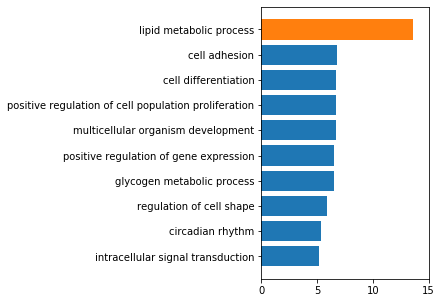

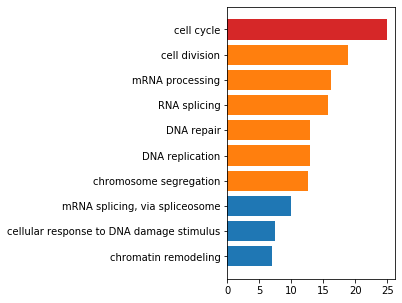

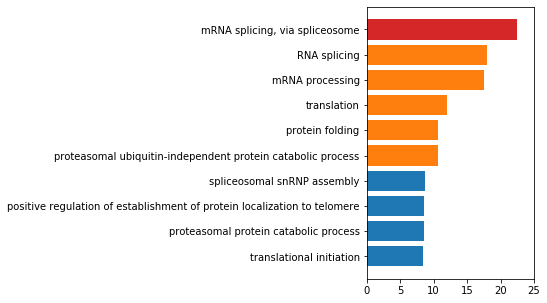

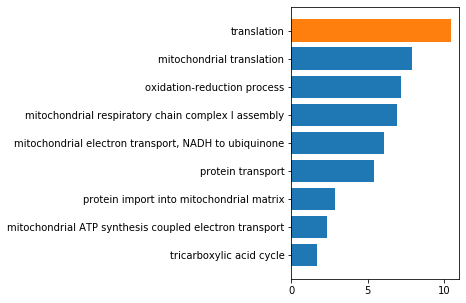

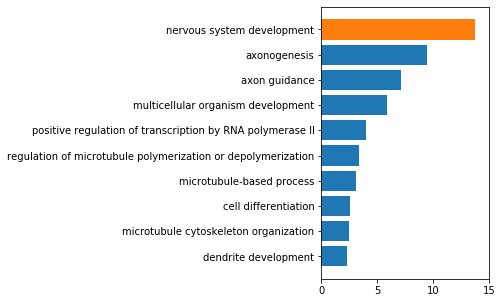

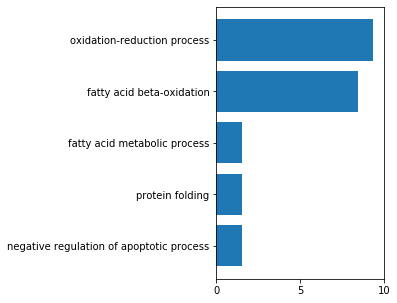

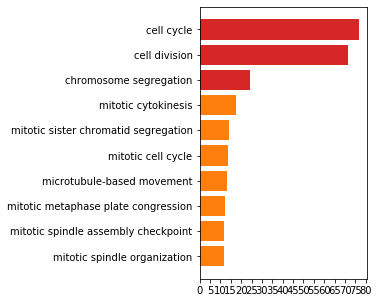

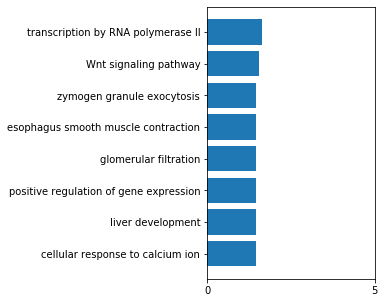

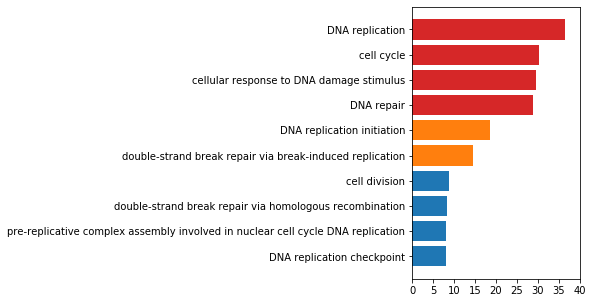

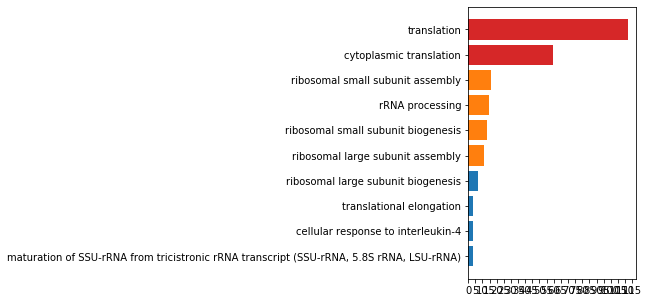

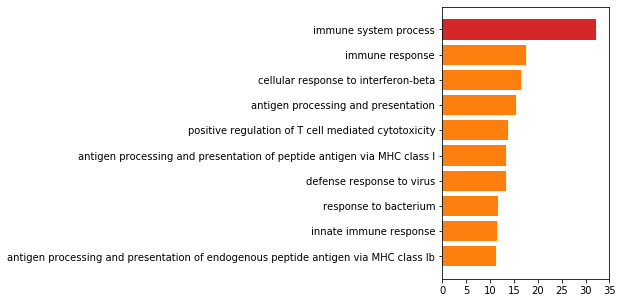

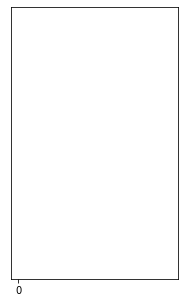

In [26]:
# Figure 4E
for cluster, _, _, goea_results_sig in goea_gene_clusters:
    print('Current gene cluster under examination: Louvain', cluster)

    print(len(goea_results_sig), 'GO terms are enriched in Louvain cluster', cluster)

    goID = []
    goName = []
    goNamespace = []
    goEnrichment = []
    goAdjP = []
    study_count = []
    study_n = []
    pop_count = []
    pop_n = []
    for goea_result in goea_results_sig:
        goID.append(goea_result.goterm.id)
        goName.append(goea_result.goterm.name)
        goNamespace.append(goea_result.goterm.namespace)
        goEnrichment.append(goea_result.enrichment)
        goAdjP.append(goea_result.p_fdr_bh)
        study_count.append(goea_result.study_count)
        study_n.append(goea_result.study_n)
        pop_count.append(goea_result.pop_count)
        pop_n.append(goea_result.pop_n)

    goea_summary = pd.DataFrame(data={'goID': goID,
                                     'goName': goName, 
                                     'goNamespace': goNamespace, 
                                     'goEnrichment': goEnrichment, 
                                     'goAdjP': goAdjP, 
                                     'study_count': study_count, 
                                     'study_n': study_n, 
                                     'pop_count': pop_count, 
                                     'pop_n': pop_n})

    goea_summary.sort_values(by='goAdjP', ascending=True, inplace=True)

    goea_summary = goea_summary[goea_summary['goEnrichment']=='e']

    goea_summary_MF = goea_summary[goea_summary['goNamespace']=='molecular_function']
    goea_summary_BP = goea_summary[goea_summary['goNamespace']=='biological_process']
    goea_summary_CC = goea_summary[goea_summary['goNamespace']=='cellular_component']

    print(goea_summary_MF.shape[0], 'MF terms are significantly enriched. ')
    print(goea_summary_BP.shape[0], 'BP terms are significantly enriched. ')
    print(goea_summary_CC.shape[0], 'CC terms are significantly enriched. ')

    #### Barplot

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 5), sharex=True)
    # plt.subplots_adjust(hspace=0.5)

    # BP
    y_pos = np.arange(min(10, goea_summary_BP.shape[0]))
    y_lab = goea_summary_BP['goName'][:10]
    data = -np.log10(goea_summary_BP['goAdjP'][:10])
    colors = np.where(data > 20, 'tab:red', np.where(data > 10, 'tab:orange', 'tab:blue') )
    
    for lab in y_lab:
        print(lab)
    
    ax.barh(y_pos, data, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_lab)
    ax.invert_yaxis()  # labels read top-to-bottom
    # axes[0].set_xlabel('- log10 adj. p-value')
#     ax.set_title('Enriched GO biological process terms')

    if len(data.tolist()) > 0:
        maxtick = int(max(data.tolist())+5)
    else:
        maxtick = 5
    ax.set_xticks(np.arange(0, maxtick, 5))
    ax.set_xticklabels(np.arange(0, maxtick, 5))
    
#    plt.show()
#     plt.savefig('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_v2/Figure2/GO/cluster'+cluster+'_BP_barchart.pdf')